# Método NN: Multilayer Perceptron
## Time Series: Pozo Izquierdo ME
## Height from the groud: 40 mtos.
### Field: wind


In [15]:
%matplotlib inline
import os
import sys
sys.path.append('/Users/tmorales/tmp/RNN-windPower/src/regressors')
import pandas as pd
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt 

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model

from models.neural_networks.utils.callback_utils import MetricCallBack
from models.neural_networks.utils.my_tensorboard import MyTensorboard

In [16]:
# cargamos el horizonte de la serie a predecir con las features
df_v40_hour_h1 = pd.read_csv('../../database/torrePozoIzquierdo_JUL_AGO_2004/torreME_features/pozo_izquierdo_torre_me_h_1.csv',
                             delimiter=';')
df_v40_hour_h1.head()

,target_date,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,target
0,2004-07-01 00:10:00,9.6,9.6,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5
1,2004-07-01 00:11:00,9.6,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2
2,2004-07-01 00:12:00,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3
3,2004-07-01 00:13:00,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3,11.7
4,2004-07-01 00:14:00,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3,11.7,12.5


In [17]:
def dataframe_split(df):
    """
    Split a pandas dataframe in three dataframe. 
    :df: pandas dataframe 
    :return: a dictionary where the value of the key is a pandas dataframe.
             each dataframe has a time measure, features and the target variable.
    """
    train_size = int((df.shape[0] * 80) / 100)
    # split: df in train and test sets
    df_train_set = df.iloc[0:train_size]
    df_test_set = df.iloc[train_size:]
    # split: train in train and validation sets
    df_train_set, df_validation_set = train_test_split(df_train_set, test_size=0.2)
    
    return {'train_set' : df_train_set,
            'validation_set': df_validation_set,
            'test_set': df_test_set}

In [18]:
data = dataframe_split(df_v40_hour_h1)
# dfs: train, validation and test set
train_set = data['train_set']
validation_set = data['validation_set']
test_set = data['test_set']

In [19]:
# bug: the original time seria has null values.
train_set = train_set.fillna(0.0)
train_set = train_set.fillna(0.0)
validation_set = validation_set.fillna(0.0)

## MLP-regression
### Hyperparameters
* n_input = 10
* n_hidden = [10, 8, 4]
* dropouts = [0, 0.4, 0.4]
* n_output = 1

In [20]:
if not os.path.exists('EXP_mlp'):
    os.makedirs('EXP_mlp')

In [21]:
# features and target columns
features_columns = train_set.columns[1:-1]
target_column = train_set.columns[-1:]

# select the values of features and target columns.
features_train_set = train_set[features_columns]
target_train_set = train_set[target_column]
features_validation_set = validation_set[features_columns]
target_validation_set = validation_set[target_column]

### Hyperparameters

In [22]:
n_input = 10
n_hidden = [10, 8, 4]
activations = ['linear', 'relu', 'relu']
dropouts = [0, 0.4, 0.4]
n_output = 1
epochs = 10
batch_size = 5000
lr = 0.001

In [23]:
# create a fully-connected topology
inputs = Input(shape=(n_input,), name='Input-Layer')
normalization_batch = BatchNormalization(name='normalization_batch')(inputs)
for neurons, dropout, activation, layer in zip(n_hidden, dropouts, activations, range(len(n_hidden))):
    if layer == 0:
        x = Dense(neurons, activation=activation, name='Hidden_{0}'.format(layer))(normalization_batch)
        if dropout != 0:
            x = Dropout(dropout)(x)
    else:
        x = Dense(neurons, activation=activation, name='Hidden_{0}'.format(layer))(x)
        if dropout != 0:
            x = Dropout(dropout)(x)
predictions = Dense(n_output, activation='linear', name='Output-Layer')(x)
model = Model(inputs=inputs, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input-Layer (InputLayer)     (None, 10)                0         
_________________________________________________________________
normalization_batch (BatchNo (None, 10)                40        
_________________________________________________________________
Hidden_0 (Dense)             (None, 10)                110       
_________________________________________________________________
Hidden_1 (Dense)             (None, 8)                 88        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
Hidden_2 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_4 (Dropout)          (None, 4)                 0         
__________

In [24]:
# plot model's topology
plot_model(model, to_file='mlp_topology.png',
           show_shapes=True, show_layer_names=True, rankdir='LR')

<img src="mlp_topology.png">

In [25]:
# compile the model
opt = Adam(lr=lr)
metrics = ['mae']
model.compile(loss='mean_squared_error', 
              optimizer=opt, 
              #metrics=metrics
              )

In [26]:
print(features_train_set.values.shape)

(55752, 10)


### Fit the model

In [32]:
%load_ext autoreload
%autoreload 2
from models.neural_networks.utils.my_tensorboard import MyTensorboard
from models.neural_networks.utils.callback_utils import MetricCallBack
from keras.callbacks import TensorBoard

# fit the model
# 1.- Callbacks
path_tb = '/Users/tmorales/tmp/RNN-windPower/notebooks/03_modelos/EXP_mlp/graph'
K_tensorboard = TensorBoard(log_dir=path_tb,
                          histogram_freq=1,
                          batch_size=batch_size,
                          write_graph=True)
my_tensorboard = MyTensorboard(log_dir='./EXP_mlp/graph',
                               histogram_freq=1,
                               batch_size=batch_size,
                               write_graph=False)
metric_callback = MetricCallBack(exp_path='EXP_mlp', 
                                 training_data=(features_train_set.values,
                                                target_train_set.values),
                                 validation_data=(features_validation_set.values,
                                                  target_validation_set.values),
                                 predict_bach_size=batch_size)
callbacks = [
    #my_tensorboard,
    tensorboard,
    #metric_callback
]
# 2.- Fit the model
history = model.fit(features_train_set.values, target_train_set.values,
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(features_validation_set.values, 
                                     target_validation_set.values),
                    callbacks=[K_tensorboard],
                   )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: Function has keyword-only arguments or annotations, use getfullargspec() API which can support them

In [22]:
# metric history
history.history.keys()

dict_keys(['val_loss', 'mse_val', 'mse', 'mae_val', 'loss', 'mae'])

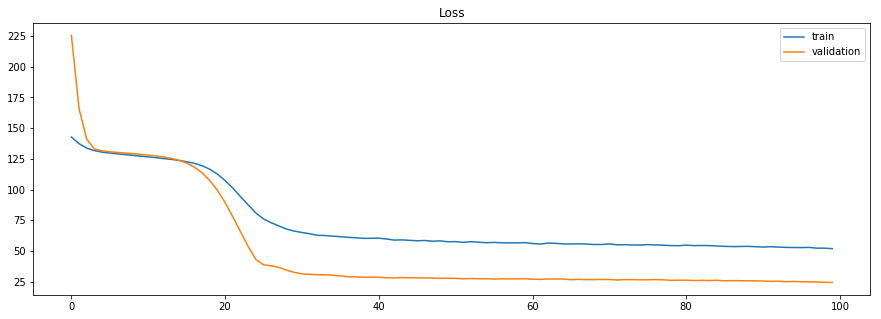

In [13]:
# plot the cost function: 
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')

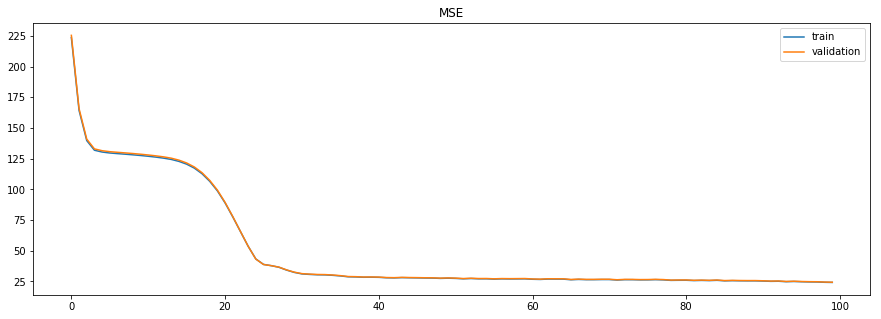

In [14]:
# plot the metric : 
plt.figure(figsize=(15,5))
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['mse_val'], label='validation')
plt.legend()
plt.title('MSE')

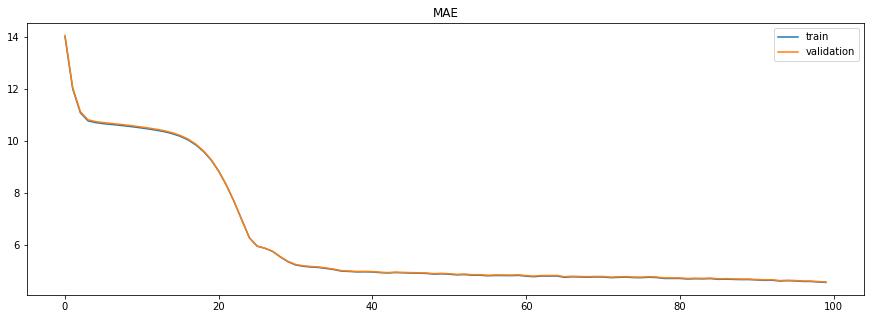

In [15]:
# plot the metric : 
plt.figure(figsize=(15,5))
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['mae_val'], label='validation')
plt.legend()
plt.title('MAE')

### Predict

In [16]:
# features test set
features_test_set = test_set[features_columns]
# predict the fitted model
predicted = model.predict(features_test_set.values)

In [17]:
# select the id and target variable from the test set
df_target = test_set[['target_date', 'target']]
df_target.set_index(['target_date'], inplace=True)
df_target.head(5)

,target
target_date,
2004-08-19 21:36:00,11.7
2004-08-19 21:37:00,12.2
2004-08-19 21:38:00,11.2
2004-08-19 21:39:00,10.2
2004-08-19 21:40:00,10.1


In [18]:
# df target: target and predictes columns
df_target.loc[:, 'predicted'] = predicted[:,0]

/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/pandas/core/indexing.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [19]:
df_target.head()

,target,predicted
target_date,,
2004-08-19 21:36:00,11.7,6.241545
2004-08-19 21:37:00,12.2,6.586960
2004-08-19 21:38:00,11.2,7.035573
2004-08-19 21:39:00,10.2,6.400546
2004-08-19 21:40:00,10.1,6.010424


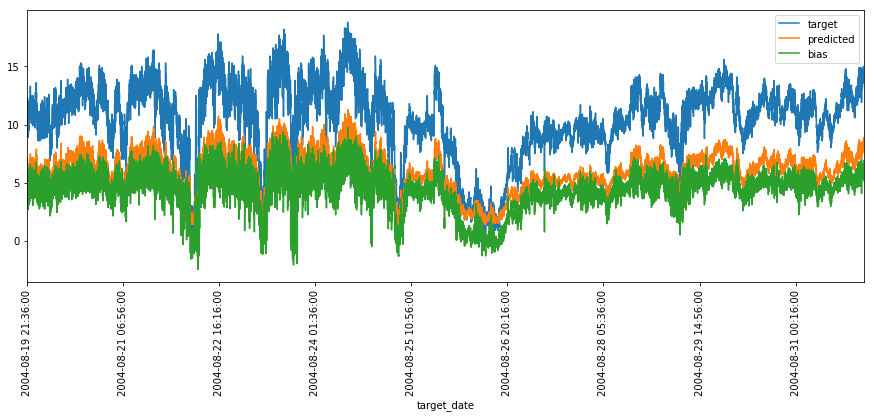

In [26]:
# plot the test set: targer and predicted variables
df_target.plot(figsize=(15,5), rot=90)

## Validation

In [27]:
# calculate the bias
df_target.loc[:,'bias'] = df_target['target'] - df_target['predicted']

/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


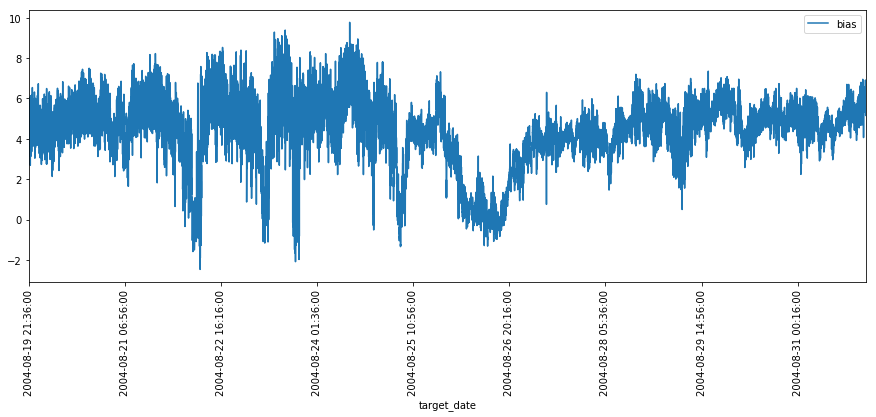

In [28]:
df_target[['bias']].plot(figsize=(15,5), rot=90)

In [13]:
!pip install tensorflow

    100% |████████████████████████████████| 39.3MB 17kB/s  eta 0:00:01
    100% |████████████████████████████████| 1.7MB 389kB/s eta 0:00:01
    100% |████████████████████████████████| 389kB 1.7MB/s eta 0:00:01
    100% |████████████████████████████████| 890kB 559kB/s eta 0:00:01
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /Users/tmorales/Library/Caches/pip/wheels/6f/85/6c/56b8e1292c6214c4eb73b9dda50f53e8e977bf65989373c962
Successfully built html5lib


In [14]:
!pip install keras